In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import zipfile
import tensorflow as tf

from keras import *
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import *
from keras.losses import *

In [3]:
# data_r = zipfile.ZipFile('..\\train.zip', 'r')
# data_r.extractall()

In [4]:
# data_r = zipfile.ZipFile('..\\test.zip', 'r')
# data_r.extractall()

In [5]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [6]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")

In [7]:
# задаём константы
IMG_WIDTH = 128                       # Ширина итогового изображения
IMG_LENGTH = 128                      # Длина итогового изображения
IMG_SHAPE  = (IMG_WIDTH, IMG_LENGTH)  # Формат изображения (ширина, длина)
CLASSES = 6 

In [8]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (IMG_WIDTH, IMG_LENGTH), method="nearest")
   input_mask = tf.image.resize(input_mask, (IMG_WIDTH, IMG_LENGTH), method="nearest")
   return input_image, input_mask

In [9]:
X_train, Y_train = resize(X_train, Y_train)
X_test, Y_test = resize(X_test, Y_test)

Объявление функций предобработки и пост обработки данных


In [10]:
# установка цвета полос
palette = {0 : (60, 16, 152), # Здания
           1 : (132, 41, 246), # Земля
           2 : (110, 193, 228), # Дороги
           3 : (254, 221, 58), # Растения
           4 : (226, 169, 41), # Вода
           5 : (155, 155, 155)} # Неразмечено

# обратное преобразование цвета в метку класса
invert_palette = {v: k for k, v in palette.items()}

# преобразование выхода нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Числовые метки для кодирования RGB-цвета """
    # zeros() возвращает новый массив указанной формы и типа, заполненный нулями.
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [11]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ Кодирование цвета RGB в полутоновый маркер """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    # принадлежность каждого пикселя классу
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8)

    # расстояние до ближайшего класса для пикселей
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 

    for c, i in palette.items():
      # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) 

      # поиск элементов меньше min_distance
      condition = min_distance > distance 

      # замена дистанции найденных элементов
      min_distance[condition] = distance[condition] 

      # замена класса найденных элементов
      arr_2d[condition] = i 

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

Предобработка исходных изображений и сегментированных изображений в ответ сети

In [12]:
# Следующий блок кода подготавливает данные для использования нейронной сетью
X_train_pred = np.array(X_train).reshape([7, IMG_WIDTH, IMG_LENGTH, 3])/255 
X_test_pred = np.array(X_test).reshape([2, IMG_WIDTH, IMG_LENGTH, 3])/255   
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [13]:
X_train_pred.shape

(7, 128, 128, 3)

Объявление топологии нейронной сети

In [14]:
def unet_model(image_size, output_classes):

    #Входной слой
    input_layer = Input(shape=image_size + (3,))
    conv_1 = Conv2D(64, 4, activation=LeakyReLU(),
                                    strides=2, padding='same', kernel_initializer='glorot_normal',
                                    use_bias=False)(input_layer)
    #Сворачиваем
    conv_1_1 = Conv2D(128, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = BatchNormalization()(conv_1_1)

    #2
    conv_2 = Conv2D(256, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_1)
    batch_norm_2 = BatchNormalization()(conv_2)

    #3
    conv_3 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_2)
    batch_norm_3 = BatchNormalization()(conv_3)

    #4
    conv_4 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_3)
    batch_norm_4 = BatchNormalization()(conv_4)

    #5
    conv_5 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    #6
    conv_6 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_5)


    #Разворачиваем
    #1
    up_1 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = Dropout(0.25)(batch_up_1)

    #2
    up_2 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = BatchNormalization()(up_2)
    batch_up_2 = Dropout(0.25)(batch_up_2)




    #3
    up_3 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = BatchNormalization()(up_3)
    batch_up_3 = Dropout(0.25)(batch_up_3)




    #4
    up_4 = Concatenate()([Conv2DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = BatchNormalization()(up_4)


    #5
    up_5 = Concatenate()([Conv2DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = BatchNormalization()(up_5)


    #6
    up_6 = Concatenate()([Conv2DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = BatchNormalization()(up_6)


    #Выходной слой
    output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2,
                                                   padding='same',
                                                   kernel_initializer='glorot_normal')(batch_up_6)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [15]:
model = unet_model(image_size=IMG_SHAPE, output_classes=CLASSES)

In [16]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
# model.summary()

In [17]:
%%time
# Обучаем модель
history = model.fit(X_train_pred, Y_train_pred, batch_size=1, epochs=100, validation_data=(X_test_pred, Y_test_pred))

Epoch 1/100
7/7 [==============================] - 11s 907ms/step - loss: 1.5737 - accuracy: 0.4655 - val_loss: 1.5203 - val_accuracy: 0.6653
Epoch 2/100
7/7 [==============================] - 5s 718ms/step - loss: 1.2869 - accuracy: 0.6231 - val_loss: 3.0137 - val_accuracy: 0.2610
Epoch 3/100
7/7 [==============================] - 5s 679ms/step - loss: 1.1573 - accuracy: 0.6615 - val_loss: 4.4903 - val_accuracy: 0.2730
Epoch 4/100
7/7 [==============================] - 5s 697ms/step - loss: 1.0392 - accuracy: 0.6778 - val_loss: 2.3313 - val_accuracy: 0.3250
Epoch 5/100
7/7 [==============================] - 5s 683ms/step - loss: 0.9626 - accuracy: 0.7098 - val_loss: 2.7946 - val_accuracy: 0.2315
Epoch 6/100
7/7 [==============================] - 5s 685ms/step - loss: 0.8534 - accuracy: 0.7410 - val_loss: 4.7092 - val_accuracy: 0.2657
Epoch 7/100
7/7 [==============================] - 5s 700ms/step - loss: 0.7737 - accuracy: 0.7640 - val_loss: 3.0475 - val_accuracy: 0.2292
Epoch 8/100


### Отрисовка точности модели (при обучении и на тестовых данных)

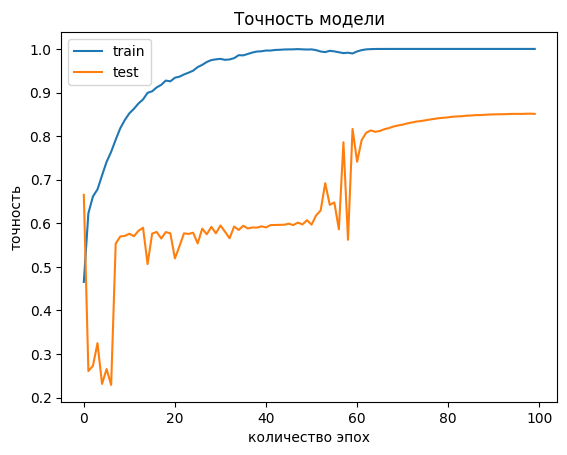

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Делаем сегментацию для двух тестовых картинок
out = model.predict(X_test_pred[:2], batch_size=1)

2/2 [==============================] - 0s 134ms/step


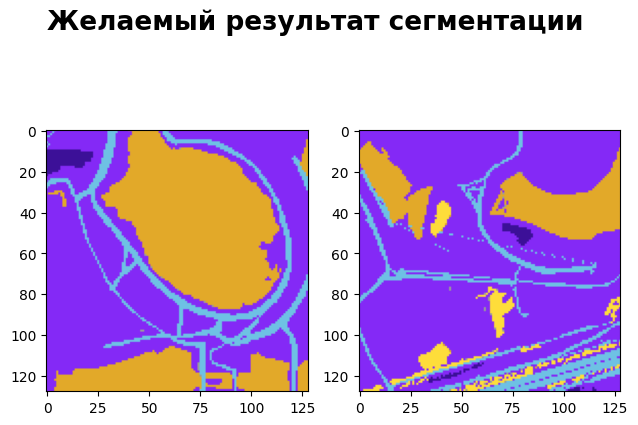

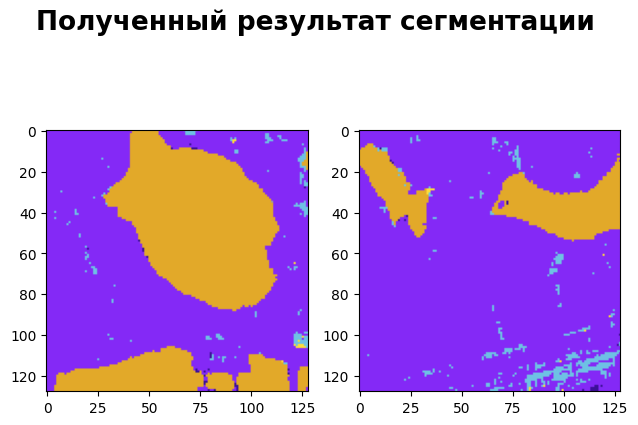

In [23]:
# Выведем 2-е тестовые картинки
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(Y_test_pred[i], axis=-1)))
plt.suptitle('Желаемый результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

# Выведем 2-е картинки полученые методом predict
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(out[i], axis=-1)))
plt.suptitle('Полученный результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

Вывод: В исследовании был использован пример с урока, дополненный моделью НС из гитхаба по котикам. После пары дней запуска, модель начала показывать что-то внятное: была проблема остановки accuracy на 60%. В данном исследовании точность модели на тестовых данных составила около 85%, при том на обучающих достигла 100% уже на 60 эпохе. Полученный результат сегментации похож на желаемый результат, но далек от идеала. Лучше всего модель выделила класс "Вода"